In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
dataset = pd.read_csv('../data/interim/dataset.csv')
dataset = dataset.drop(columns=['timestamp'])

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

dataset['user_id'] = user_encoder.fit_transform(dataset['user_id'])
dataset['item_id'] = item_encoder.fit_transform(dataset['item_id'])

In [9]:
class RecommenderDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values
        self.columns = dataframe.columns

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

In [10]:
class EmbeddingRecommenderModel(nn.Module):
    def __init__(self, user_size, item_size, embedding_size=64):
        super(EmbeddingRecommenderModel, self).__init__()
        self.user_embedding = nn.Embedding(user_size, embedding_size)
        self.item_embedding = nn.Embedding(item_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)

    def forward(self, user_id, item_id):
        user_embed = self.user_embedding(user_id)
        item_embed = self.item_embedding(item_id)
        x = torch.cat([user_embed, item_embed], dim=1)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.relu2(self.bn2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch 1/10, Training Loss: 0.009047485731477633, Validation Loss: 0.0006889653512107514
Epoch 2/10, Training Loss: 0.0006204451714105235, Validation Loss: 0.0004941690522582722
Epoch 3/10, Training Loss: 0.00041042558157125016, Validation Loss: 0.0002806501592133672
Epoch 4/10, Training Loss: 0.0003105655161408129, Validation Loss: 0.0002553645307557052
Epoch 5/10, Training Loss: 0.00022968871790486056, Validation Loss: 0.00021335153970814872
Epoch 6/10, Training Loss: 0.00018383529469481608, Validation Loss: 0.0002170057699843555
Epoch 7/10, Training Loss: 0.00010972235556246945, Validation Loss: 6.400326540100687e-05
Epoch 8/10, Training Loss: 0.0001950390467030058, Validation Loss: 8.15069835598581e-05
Epoch 9/10, Training Loss: 6.982527890356687e-05, Validation Loss: 3.479267272668571e-05
Epoch 10/10, Training Loss: 7.848408680499527e-05, Validation Loss: 4.768905305542368e-05


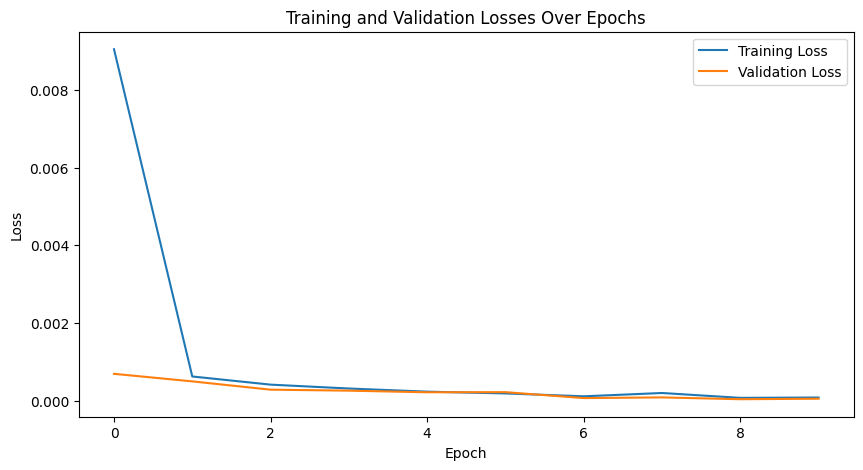

In [28]:
class RecommenderSystem:
    def __init__(self, dataframe, batch_size=64, lr=0.001, epochs=10, validation_split=0.2):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        user_size = dataframe['user_id'].nunique()
        item_size = dataframe['item_id'].nunique()
        self.model = EmbeddingRecommenderModel(user_size, item_size).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_size = batch_size
        self.epochs = epochs
        self.dataset = dataframe

        train_data, val_data = train_test_split(dataframe, test_size=validation_split, random_state=42)
        self.train_dataset = RecommenderDataset(train_data)
        self.val_dataset = RecommenderDataset(val_data)


    def train(self):
        train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        train_losses = []
        val_losses = []

        for epoch in range(self.epochs):
            self.model.train()
            running_loss = 0.0

            for batch in train_loader:
                batch = batch.to(self.device)
                inputs, targets = batch[:, :-1], batch[:, -1]
                user_ids = inputs[:, 0].long()
                item_ids = inputs[:, 1].long()
                self.optimizer.zero_grad()
                outputs = self.model(user_ids, item_ids)
                loss = self.criterion(outputs.squeeze(), targets)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            # Validation loss
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in val_loader:
                    val_batch = val_batch.to(self.device)
                    val_user_ids = val_batch[:, 0].long()
                    val_item_ids = val_batch[:, 1].long()
                    val_outputs = self.model(val_user_ids, val_item_ids)
                    val_loss += self.criterion(val_outputs.squeeze(), val_batch[:, -1]).item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch + 1}/{self.epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {avg_val_loss}")

            train_losses.append(running_loss / len(train_loader))
            val_losses.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(self.model.state_dict(), '../models/best_pytorch_model.pth')

        self.model.load_state_dict(torch.load('../models/best_pytorch_model.pth'))

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Losses Over Epochs')
        plt.legend()
        plt.show()
    
    def predict_top_k(self, user_id, top_k=5):
        self.model.eval()
        
        all_item_ids = torch.arange(self.model.item_embedding.num_embeddings, device=self.device)
        user_ids = torch.full((len(all_item_ids),), user_id, dtype=torch.long, device=self.device)
        
        with torch.no_grad():
            scores = self.model(user_ids, all_item_ids)
        
        watched = self.dataset[self.dataset['user_id'] == user_id]['item_id'].values.tolist()
        unwatched_item_ids = torch.tensor(list(set(all_item_ids.tolist()) - set(watched)), device=self.device)
        unwatched_scores = scores[unwatched_item_ids]
        _, indices = torch.topk(unwatched_scores.view(-1), top_k)
        top_k_items = unwatched_item_ids[indices].cpu().numpy().tolist()
        
        return top_k_items


recommender_system = RecommenderSystem(dataset)
recommender_system.train()

In [29]:
genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('../data/raw/ml-100k/u.item', sep='|', encoding='latin-1')
movies.columns = ['item_id', 'title', 'date', 'release_date', 'url'] + genres

In [30]:
def print_top_k_recommendations(user_id, top_k=5):
    top_k_items = recommender_system.predict_top_k(user_id, top_k)
    print(f"Top {top_k} recommendations for user {user_id}")
    print(movies[movies['item_id'].isin(top_k_items)][['title', 'date']])
    print()

In [31]:
print_top_k_recommendations(17)

Top 5 recommendations for user 17
                  title         date
1     Four Rooms (1995)  01-Jan-1995
6           Babe (1995)  01-Jan-1995
407         Jack (1996)  07-Aug-1996
1341  Lotto Land (1995)  01-Jan-1995
1477    Reckless (1995)  01-Jan-1995



In [32]:
print_top_k_recommendations(98)

Top 5 recommendations for user 98
                                                  title         date
921                        Raise the Red Lantern (1991)  01-Jan-1991
923                                Unforgettable (1996)  23-Feb-1996
1343  Day the Sun Turned Cold, The (Tianguo niezi) (...  01-Jan-1994
1352                               Venice/Venice (1992)  01-Jan-1992
1478                          Herbie Rides Again (1974)  01-Jan-1974



In [33]:
print_top_k_recommendations(210)

Top 5 recommendations for user 210
                     title         date
766          Casper (1995)  01-Jan-1995
777       Drop Zone (1994)  01-Jan-1994
824    Phantom, The (1996)  07-Jun-1996
852       Bad Taste (1987)  01-Jan-1987
1106  Feast of July (1995)  01-Jan-1995



In [34]:
print_top_k_recommendations(555)

Top 5 recommendations for user 555
                          title         date
12           Postino, Il (1994)  01-Jan-1994
199         Evil Dead II (1987)  01-Jan-1987
717       Canadian Bacon (1994)  01-Jan-1994
1001      That Darn Cat! (1997)  14-Feb-1997
1298  'Til There Was You (1997)  30-May-1997



In [36]:
print_top_k_recommendations(900)

Top 5 recommendations for user 900
                                   title         date
58             Three Colors: Blue (1993)  01-Jan-1993
94     Terminator 2: Judgment Day (1991)  01-Jan-1991
134  Mr. Smith Goes to Washington (1939)  01-Jan-1939
777                     Drop Zone (1994)  01-Jan-1994
837                     Loch Ness (1995)  01-Jan-1995

